# Mid Semester Project - Reinforcements Learning
Dear students,<br> this is the template notebook. Please copy it by clicking on the "File" tab and then on "Save a copy into drive".

---
<br>

### Name and ID:
Student 1:
<br>
Student 2:
<br><br>
<img src="https://raw.githubusercontent.com/Farama-Foundation/Minigrid/master/minigrid-text.png">

### https://minigrid.farama.org/

# Installs

In [169]:
'''
%%capture
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.0'
!pip install gym
!pip install gym-minigrid
!pip install pygame
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet
!pip install gym
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install -U --no-cache-dir gdown --pre
'''

"\n%%capture\n!sudo apt-get update\n!sudo apt-get install -y xvfb ffmpeg freeglut3-dev\n!pip install 'imageio==2.4.0'\n!pip install gym\n!pip install gym-minigrid\n!pip install pygame\n!apt-get install python-opengl -y\n!apt install xvfb -y\n!pip install pyvirtualdisplay\n!pip install piglet\n!pip install gym\n!apt-get install python-opengl -y\n!apt install xvfb -y\n!pip install -U --no-cache-dir gdown --pre\n"

# Imports

In [170]:
import numpy as np
import gym
from gym import logger as gymlogger
from gym.utils import seeding
from gym import error, spaces, utils
gymlogger.set_level(40) # error only
import glob
import io
import base64
import os
import random
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
%load_ext autoreload
%autoreload 2
import math
import glob
from pyvirtualdisplay import Display
from IPython.display import HTML
from IPython import display as ipythondisplay
import pygame
import pyvirtualdisplay
import imageio
import IPython
import time
import seaborn as sns
import gym_minigrid
from gym_minigrid.wrappers import *
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from numpy import load
from numpy import save
import numpy as np
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Display utils
Note: this cell was changed in order to support also working on windows os, as PyVirtualDisplay doesn't work on windows. link for reference: https://stackoverflow.com/questions/43270513/is-there-a-windows-equivalent-to-pyvirtualdisplay

In [171]:
import os
import sys
if os.name == 'nt': # this means we run locally on windows
    sys.path.append('../')

In [172]:
import cv2
from base64 import b64encode

if os.name == 'nt': # this means we run locally on windows
  video_count = 0
  def create_video(images):
    global video_count
    video_count += 1
    video_name = f'video_{video_count}.mp4'
    frame = images[0]
    height, width, layers = frame.shape

    video = cv2.VideoWriter(video_name, 0, 3, (width,height))

    for image in images:
      video.write(image)

    cv2.destroyAllWindows()
    video.release()
  
    mp4 = open(video_name,'rb').read()   
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    display(
      HTML(
            """
                <video width=400 controls>
                        <source src="%s" type="video/mp4">
                </video>
            """ % data_url
          )   
    )
    print(f'video file name: {video_name}')
      
else: # this is posix, as it runs online. use assigment video solution
  def create_video(images):
    video_filename = 'imageio.mp4'
    with imageio.get_writer(video_filename, fps=10) as video:
        for image in images: video.append_data(image)

    video = open(video_filename,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="640" height="480" controls>
      <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())

    return IPython.display.HTML(tag)
  display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start() 

# Env

In [173]:
from __future__ import annotations
from gym_minigrid.minigrid import COLOR_NAMES
from gym_minigrid.minigrid import Grid
from gym_minigrid.minigrid import MissionSpace
from gym_minigrid.minigrid import Door, Goal, Key, Wall, Lava, Floor
from minigrid_x import MiniGridEnv
from gym import spaces
import random


class RandomKeyMEnv_10(MiniGridEnv):
    def __init__(
        self,
        size=10,
        agent_start_pos=(1, 1),
        agent_start_dir=0,
        max_steps: int | None = None,
        **kwargs,
    ):
        self.agent_start_pos = agent_start_pos
        self.agent_start_dir = agent_start_dir

        mission_space = MissionSpace(mission_func=self._gen_mission)

        if max_steps is None:
            max_steps = 4 * size**2

        super().__init__(
            mission_space=mission_space,
            grid_size=size,
            # Set this to True for maximum speed
            see_through_walls=True,
            max_steps=max_steps,
            **kwargs,
        )
        self.partition_col = 3
        self.walls_init = [(self.partition_col, i) for i in range(0, self.grid.height)]
        self.goal_pos = (self.grid.width - 2, self.grid.height - 2)


    def get_pass_location(self):
      return (self.partition_col, self.pass_loc)

    def get_partition_column(self):
      return self.partition_col

    @staticmethod
    def _gen_mission():
        return "grand mission"

    def get_k_pos(self):
      return self.key_pos

    def get_d_pos(self):
      return self.door_pos

    def _gen_grid(self, width, height):
        # Place Dor in random location within all column the partition
        self.pass_loc = random.choice([op_row for op_row in range(1, self.unwrapped.width-1)])

        # Create an empty grid
        self.grid = Grid(width, height)

        # Generate the surrounding walls
        self.grid.wall_rect(0, 0, width, height)

        # Generate verical separation wall
        # for i in range(0, height):
        #     self.grid.set(5, i, Wall())


        for column, row in self.walls_init:
          self.grid.set(column, row, Wall())

        # Place Key in random location within all the free spaces left to the partition
        self.key_pos = (random.choice([k_col for k_col in range(1,self.partition_col)]), random.choice([k_row for k_row in range(2,self.unwrapped.height-1)]))
        self.door_pos = (self.partition_col, self.pass_loc)

        self.env_door = Door(COLOR_NAMES[0], is_locked=True)

        # Place the Lava
        # self.grid.set(4, 6, Lava())

        # Place the door and key
        self.grid.set(self.door_pos[0], self.door_pos[1], self.env_door)
        self.grid.set(self.key_pos[0], self.key_pos[1], Key(COLOR_NAMES[0]))
        self.goal_pos = (width - 2, height - 2)
        # Place a goal square in the bottom-right corner
        self.put_obj(Goal(), self.goal_pos[0], self.goal_pos[1])

        # Place the agent
        if self.agent_start_pos is not None:
            self.agent_pos = self.agent_start_pos
            self.agent_dir = self.agent_start_dir
        else:
            self.place_agent()

        self.mission = "grand mission"

class RandomEmptyEnv_10(MiniGridEnv):
    def __init__(
        self,
        size=10,
        agent_start_pos=(1, 1),
        agent_start_dir = 0,
        max_steps: int | None = None,
        **kwargs,
    ):

        self.agent_start_pos = agent_start_pos
        self.agent_start_dir = agent_start_dir



        agent_start_x_loc =random.randint(1, 6)
        agent_start_y_loc =random.randint(1, 6)

        self.agent_start_pos = (agent_start_x_loc,agent_start_y_loc)


        mission_space = MissionSpace(mission_func=self._gen_mission)

        if max_steps is None:
            max_steps = 4 * size**2

        super().__init__(
            mission_space=mission_space,
            grid_size=size,
            # Set this to True for maximum speed
            see_through_walls=True,
            max_steps=max_steps,
            **kwargs,
        )
        self.action_space = spaces.Discrete(3)
        self.walls_init = []

        # change 21-09 for random env
        self.not_goal_loc = [(col,row) for col in range(self.unwrapped.width) for row in range(self.unwrapped.height) if row == 0 or row == (self.unwrapped.width-1) or col == 0 or col == (self.unwrapped.height-1)]
        self.not_goal_loc.append(self.agent_start_pos)
        self.goal_pos = (self.grid.width - 2, self.grid.height - 2)

    def reset(self, **kwargs):
        # Randomize start position each time environment is reset
        agent_start_x_loc = random.randint(1, 6)
        agent_start_y_loc = random.randint(1, 6)
        self.agent_start_pos = (agent_start_x_loc, agent_start_y_loc)

        self.values = [0, 1, 2, 3]
        self.agent_start_dir = random.choice(self.values)

        # Recalculate not_goal_loc as it depends on the agent's start position
        self.not_goal_loc = [(col, row) for col in range(self.unwrapped.width) for row in range(self.unwrapped.height)
                             if row == 0 or row == (self.unwrapped.width - 1) or col == 0 or col == (self.unwrapped.height - 1)]
        self.not_goal_loc.append(self.agent_start_pos)

        # Call the reset method of the parent class
        return super().reset(**kwargs)

    @staticmethod
    def _gen_mission():
        return "grand mission"

    def get_k_pos(self):
      return self.key_pos

    def get_d_pos(self):
      return self.door_pos

    def get_g_pos(self):
      return self.goal_pos

    def _gen_grid(self, width, height):
        # Create an empty grid
        self.grid = Grid(width, height)

        # Generate the surrounding walls
        self.grid.wall_rect(0, 0, width, height)

        # Generate verical separation wall
        # for i in range(0, height):
        #     self.grid.set(5, i, Wall())


        for column, row in self.walls_init:
          self.grid.set(column, row, Wall())

        self.key_pos = (6, 5)
        self.door_pos = (6, 7)

        self.env_door = Door(COLOR_NAMES[0], is_locked=True)

        # Place the Lava
        # self.grid.set(4, 6, Lava())

        # Place the door and key
        # self.grid.set(self.door_pos[0], self.door_pos[1], self.env_door)
        # self.grid.set(self.key_pos[0], self.key_pos[1], Key(COLOR_NAMES[0]))



        ## change 21-09 for random env - add player position
        # self.goal_pos = (0, 0)
        # while self.goal_pos in self.not_goal_loc:
        #   self.goal_pos = (random.randint(1, width - 2), random.randint(1, height - 2))
        self.goal_pos = random.choice([(8,1), (8,8), (1,8)])


        self.put_obj(Goal(), self.goal_pos[0], self.goal_pos[1])

        # Place a goal square in the bottom-right corner
        # self.put_obj(Goal(), width - 2, height - 2)


        # Place the agent
        if self.agent_start_pos is not None:
            self.agent_pos = self.agent_start_pos
            self.agent_dir = self.agent_start_dir
        else:
            self.place_agent()

        self.mission = "grand mission"




# Wrappers

In [174]:
import gym
from gym import spaces
from gym_minigrid.minigrid import OBJECT_TO_IDX, COLOR_TO_IDX
import copy
max_env_steps = 100

class SimFlatObsWrapper(gym.core.ObservationWrapper):
    """Fully observable gridworld returning a flat grid encoding."""

    def __init__(self, env):
        super().__init__(env)

        # Since the outer walls are always present, we remove left, right, top, bottom walls
        # from the observation space of the agent. There are 3 channels, but for simplicity
        # in this assignment, we will deal with flattened version of state.

        self.observation_space = spaces.Box(
            low=0,
            high=255,
            shape=((self.env.width-2) * (self.env.height-2) * 3,),  # number of cells
            dtype='uint8'
        )
        self.unwrapped.max_steps = max_env_steps

        self.get_init_map()

    def observation(self, obs):
        # this method is called in the step() function to get the observation
        # we provide code that gets the grid state and places the agent in it
        env = self.unwrapped
        full_grid = env.grid.encode()
        full_grid[env.agent_pos[0]][env.agent_pos[1]] = np.array([
            OBJECT_TO_IDX['agent'],
            COLOR_TO_IDX['red'],
            env.agent_dir
        ])
        full_grid = full_grid[1:-1, 1:-1]   # remove outer walls of the environment (for efficiency)

        flattened_grid = full_grid.ravel()
        return flattened_grid

    def is_carrying_key(self):
        if 'Key' in str(self.unwrapped.carrying):
          return True
        return False

    def is_door_open(self):
        return self.unwrapped.env_door.is_open

    def get_position(self):
        return self.unwrapped.agent_pos

    def get_direction(self):
        return self.unwrapped.agent_dir

    def get_direction_str(self):
        return self.unwrapped.AGENT_DIR_TO_STR[self.unwrapped.agent_dir]

    def is_wall_front_pos(self):
      if 0 in self.unwrapped.front_pos or (self.unwrapped.height-1) in self.unwrapped.front_pos:
        return True
      return (tuple(self.unwrapped.front_pos) in self.unwrapped.walls_init)

    def get_goal_pos(self):
        return self.unwrapped.goal_pos

    def get_init_map(self):
      # outer walls
      map_u = [[1 if i == 0 or i == (self.unwrapped.height-1) or j == 0 or j == (self.unwrapped.width-1) else 0 for j in range(self.unwrapped.width)] for i in range(self.unwrapped.height)]
      # inner walls
      for loc in self.unwrapped.walls_init: map_u[loc[1]][loc[0]] = 1
      self.init_map = map_u

    def get_updated_map(self):
      map_up = copy.deepcopy(self.init_map)
      # agent position
      agent_col, agent_row = self.unwrapped.agent_pos
      map_up[agent_row][agent_col] = 'P'
      # goal
      curr_goal_pos = self.get_goal_pos()
      map_up[curr_goal_pos[1]][curr_goal_pos[0]] = 'G'
      return map_up

    def is_door_front_pos(self):
      return (tuple(self.unwrapped.front_pos) == self.unwrapped.get_d_pos())

    def is_key_front_pos(self):
      return (tuple(self.unwrapped.front_pos) == self.unwrapped.get_k_pos())

    def render(self, *args, **kwargs):
        """This removes the default visualization of the partially observable field of view."""
        return self.unwrapped.render()


class KeyFlatObsWrapper(gym.core.ObservationWrapper):
    """Fully observable gridworld returning a flat grid encoding."""

    def __init__(self, env):
        super().__init__(env)

        # Since the outer walls are always present, we remove left, right, top, bottom walls
        # from the observation space of the agent. There are 3 channels, but for simplicity
        # in this assignment, we will deal with flattened version of state.

        self.observation_space = spaces.Box(
            low=0,
            high=255,
            shape=((self.env.width-2) * (self.env.height-2) * 3,),  # number of cells
            dtype='uint8'
        )
        self.unwrapped.max_steps = max_env_steps

        self.get_init_map()

    def observation(self, obs):
        # this method is called in the step() function to get the observation
        # we provide code that gets the grid state and places the agent in it
        env = self.unwrapped
        full_grid = env.grid.encode()
        full_grid[env.agent_pos[0]][env.agent_pos[1]] = np.array([
            OBJECT_TO_IDX['agent'],
            COLOR_TO_IDX['red'],
            env.agent_dir
        ])
        full_grid = full_grid[1:-1, 1:-1]   # remove outer walls of the environment (for efficiency)

        flattened_grid = full_grid.ravel()
        return flattened_grid

    def is_carrying_key(self):
        if 'Key' in str(self.unwrapped.carrying):
          return True
        return False

    def is_door_open(self):
        return self.unwrapped.env_door.is_open

    def get_position(self):
        return self.unwrapped.agent_pos

    def get_direction(self):
        return self.unwrapped.agent_dir

    def get_direction_str(self):
        return self.unwrapped.AGENT_DIR_TO_STR[self.unwrapped.agent_dir]

    def is_wall_front_pos(self):
      if 0 in self.unwrapped.front_pos or (self.unwrapped.height-1) in self.unwrapped.front_pos:
        return True
      return (tuple(self.unwrapped.front_pos) in self.unwrapped.walls_init)

    def get_goal_pos(self):
      return self.unwrapped.goal_pos

    def get_door_pos(self):
      return self.unwrapped.door_pos

    def get_key_pos(self):
      return self.unwrapped.key_pos

    def get_init_map(self):
      # outer walls
      map_u = [[1 if i == 0 or i == (self.unwrapped.height-1) or j == 0 or j == (self.unwrapped.width-1) else 0 for j in range(self.unwrapped.width)] for i in range(self.unwrapped.height)]
      # inner walls
      for loc in self.unwrapped.walls_init: map_u[loc[1]][loc[0]] = 1
      # map_u[self.unwrapped.width-2][self.unwrapped.height-2] = 'G'
      self.init_map = map_u

    def get_updated_map(self):
      map_up = copy.deepcopy(self.init_map)
      # agent position
      agent_col, agent_row = self.unwrapped.agent_pos
      map_up[agent_row][agent_col] = 'P'
      if not self.is_door_open():
        door_col, door_row = self.unwrapped.door_pos
        map_up[door_row][door_col] = 'D'
        if not self.is_carrying_key():
          key_col, key_row = self.unwrapped.key_pos
          map_up[key_row][key_col] = 'K'
      # goal
      curr_goal_pos = self.get_goal_pos()
      map_up[curr_goal_pos[1]][curr_goal_pos[0]] = 'G'

      return map_up

    def is_door_front_pos(self):
      return (tuple(self.unwrapped.front_pos) == self.unwrapped.get_d_pos())

    def is_key_front_pos(self):
      return (tuple(self.unwrapped.front_pos) == self.unwrapped.get_k_pos())

    def render(self, *args, **kwargs):
        """This removes the default visualization of the partially observable field of view."""
        return self.unwrapped.render()

Environment Customization:

In [175]:
from enum import Enum
from abc import ABC, abstractmethod

agent_directions_space = 4
key_state_space = 2
door_state_space = 2

key_picked_up_reward = 1 # these are constant rewards
door_unlocked_reward = 1

class Direction(Enum):
    RIGHT = 0
    DOWN = 1
    LEFT = 2
    UP = 3

class StateRepresentation(Enum):
    IMAGE = 'image'
    ENCODED = 'encoded'

class EnvWrapper(gym.Env, ABC):
    '''
    This wrapper enables environment customization
    '''
    def __init__(self, env, step_reward=-0.01, goal_reward=10, state_representation=StateRepresentation.ENCODED):
        '''
        Initializes the EnvWrapper.

        Args:
            env (gym.Env): The Gym environment to be wrapped. Important: this env must be initialized before wrapping (use env.reset())
            step_reward (float, optional): The per-step reward or penalty. Default is -0.01.
            goal_reward (float, optional): The reward for reaching the goal. Default is 10.
            state_representation (StateRepr, optional): The state representation mode.
                                                        Use StateRepr.IMAGE for a full image representation, or StateRepr.ENCODED for an encoded version
                                                        Default is StateRepr.ENCODED
        '''
        self.state_representation = state_representation

        self.source_env = env
        self.set_params(step_reward, goal_reward)
        self.reset()

    def reset(self): # open gym default implementation changes the board. override, as we do not want to change the board upon reset every time
        self.env = copy.deepcopy(self.source_env)
        return self.get_current_state()

    def set_params(self, step_reward, goal_reward):
        self.step_reward = step_reward
        self.goal_reward = goal_reward

    def get_current_state(self):
        if StateRepresentation.IMAGE == self.state_representation:
            current_state = self.env.render()
        else:
            current_state = self.get_encoded_current_state()
        return current_state

    def render(self):
        return self.env.render()

    def get_state_dim(self):
        if StateRepresentation.IMAGE == self.state_representation:
            state_dim = self.env.render().shape
        else: # this is encoded mode
            state_dim = self.get_encoded_state_dim()
        return state_dim

    def get_board_dims(self):
        cols = self.env.width - 2
        rows = self.env.height - 2
        return cols, rows

    def get_action_dim(self):
        return self.env.action_space.n

    def sample_action(self):
        available_actions = self.get_available_actions()
        sampled_action = random.choice(available_actions)
        return sampled_action

    def get_agent_position(self):
        col, row = self.env.get_position()
        return col - 1, row - 1

    @abstractmethod
    def get_available_actions(self):
        pass

    @abstractmethod
    def get_encoded_state_dim(self):
        pass

    @abstractmethod
    def get_encoded_current_state(self):
        pass

    @abstractmethod
    def step(self, action):
        pass

class EmptyEnvWrapper(EnvWrapper):
    def get_available_actions(self):
        available_actions = [0, 1]
        if not self.env.is_wall_front_pos(): # the agent is not standing in front of a wall - if so, we can proceed forward (2)
            available_actions.append(2)
        return available_actions

    def get_encoded_state_dim(self):
        cols, rows = self.get_board_dims()
        return cols, rows, agent_directions_space

    def get_encoded_current_state(self):
        agent_col, agent_row = self.get_agent_position()
        agent_direction = self.env.get_direction()
        state = (agent_col, agent_row, agent_direction)  # remove extra row \ col in the board perimeter
        return state

    def step(self, action):
        _ = self.env.step(action)
        s_tag = self.get_current_state()
        done = self.env.get_goal_pos() == self.env.get_position() # compare agent location to target location
        r = self.goal_reward if done else self.step_reward
        return s_tag, r, done

class KeyEnvWrapper(EnvWrapper):
    def reset(self):
        self.was_key_picked_up = False
        self.was_door_unlocked = False
        return super().reset()

    def get_available_actions(self):
        available_actions = [0, 1]

        if (not self.env.is_carrying_key() and
                self.env.is_key_front_pos()):  # the agent is fronting a key - if so, we can use pick up action (3)
            available_actions.append(3)
        elif (not self.env.is_door_open() and
              self.env.is_carrying_key() and
              self.env.is_door_front_pos()):  # the agent is fronting a door it can open - if so, we can use toggle action (5)
            available_actions.append(5)
        elif (not self.env.is_wall_front_pos() or
            self.env.is_door_front_pos() and self.env.is_door_open()):  # the agent is not fronting a key, a closed door or a wall - if so, we can proceed forward (2)
            available_actions.append(2)

        return available_actions

    def get_encoded_state_dim(self):
        cols, rows = self.get_board_dims()
        return cols, rows, agent_directions_space, key_state_space, door_state_space  # add 2 more for key carring and door opening

    def get_encoded_current_state(self):
        '''
        Note: the state holds the knowledge of the agent: the agent knows where it is and what its direction is,
        as well as some history of its actions: whether it has picked up the key or unlocked the door for the first time
        '''
        agent_col, agent_row = self.get_agent_position()
        agent_direction = self.env.get_direction()
        state = agent_col, agent_row, agent_direction, int(self.was_key_picked_up), int(self.was_door_unlocked)
        return state

    def step(self, action):
        # First - log current state
        agent_had_key = self.env.is_carrying_key()
        door_was_opened = self.env.is_door_open()

        # now - perform the action and check its outcome
        _ = self.env.step(action)
        agent_has_key = self.env.is_carrying_key()
        door_is_opened = self.env.is_door_open()
        done = self.env.get_goal_pos() == self.env.get_position()

        if done:
            r = self.goal_reward
        elif not agent_had_key and agent_has_key and not self.was_key_picked_up:  # the agent picked up the key for the first time
            self.was_key_picked_up = True
            r = key_picked_up_reward
        elif not door_was_opened and door_is_opened and not self.was_door_unlocked: # the door is opened for the first time
            self.was_door_unlocked = True
            r = door_unlocked_reward
        else: # this is a regular step
            r = self.step_reward

        s_tag = self.get_current_state()

        return s_tag, r, done

# Q-Learning algorithm

The Q-learning algorithm:

In [200]:
def create_policy(Q):
    q_snapshot = Q.copy()
    def policy(state): return np.argmax(q_snapshot[state][:])  # return a greedy policy
    return policy

def q_learning(env, alpha, gamma, epsilon, ep_decay, num_episodes, steps_cutoff):
    '''
    Q-learning algorithm.

    Params relevant to the env:
    :param env: the OpenAI env wrapped with a Wrapper object

    Params relevant to the algorithm:
    :param alpha: learning rate
    :param gamma: discount factor
    :param epsilon: exploration rate
    :param ep_decay: decaying epsilon value
    :param num_episodes: number of episodes for training
    :param steps_cutoff: maximal steps for episode

    :return: learnt policy (at mid and end of training) + stats monitoring the training process: states_visits_mean, done_counter, episodes_steps (count), episodes_rewards (sum)
    '''

    # Create Q table of size |S| x |A| where:
    # S = varying state size, with columns and rows being the first 2 dimentions:
    # e.g. for empty-env: (agent col, agent row, agent direction) and for key-env (agent col, agent row, agent direction, is_carrying_key, is_door_unlocked)
    # A is in the set {turn right, turn left, move forward}

    # We initialize values in the table, Q(terminal state) = 0
    state_dim = env.get_state_dim()
    action_dim = env.get_action_dim()
    Q = np.zeros(state_dim + (action_dim,), dtype=np.float64)

    cols, rows = env.get_board_dims()
    states_visits_count = np.zeros([cols, rows], dtype=float) # Initialize stats' data structures

    done_count = 0
    episodes_steps = []
    episodes_rewards = []

    for ep in range(1, num_episodes+1):
        #print(f'start ep: {ep}')
        s = env.reset()
        states_visits_count[s[0], s[1]] += 1

        done = False
        steps_count = 0
        reward_sum = 0

        while not done and steps_count < steps_cutoff:
            # Choose an action a based on current policy (e.g. 𝜀 − 𝑔𝑟𝑒𝑒𝑑𝑦)
            if np.random.uniform(0, 1) < epsilon:
                a = env.sample_action()
            else:
                a = np.argmax(Q[s][:])

            # You get a reward r. You are now in state s’
            s_tag, r, done = env.step(a)

            # Choose an action a’ from s’ based on current policy.
            q_value = np.max(Q[s_tag][:])
            Q[s][a] = Q[s][a] + alpha * (r + gamma * q_value - Q[s][a])

            if s[0:2] != s_tag[0:2]: # if the agent moved to a new location on the board
                states_visits_count[s[0], s[1]] += 1
            reward_sum += r
            steps_count += 1

            s = s_tag

        epsilon = ep_decay * epsilon # Decay exploration rate

        if done:
            done_count += 1
        episodes_steps.append(steps_count)
        episodes_rewards.append(reward_sum)

        if num_episodes // 2 == ep:
            mid_train_policy = create_policy(Q)

    policy = create_policy(Q)

    return mid_train_policy, policy, states_visits_count / num_episodes, done_count, episodes_steps, episodes_rewards

Policy video streaming:

In [176]:
def stream_policy(env, policy, iter_tresshold=None):
  # Step 1: collect images
  state = env.reset()
  start_time = time.time()
  done = False
  iter = 0
  images = []
  images.append(cv2.cvtColor(env.render(), cv2.COLOR_RGB2BGR)) 

  while not(iter_tresshold is not None and iter >= iter_tresshold) and not done:
    time_passed = int(time.time() - start_time)
    if done or time_passed > 3:
      break
    iter +=1
    action = policy(state)
    state, reward, done = env.step(action)
    images.append(cv2.cvtColor(env.render(), cv2.COLOR_RGB2BGR)) 
  # Than - create video
  return create_video(images)

# Experiments

The parameters and hyperparameters:

In [178]:
ENV_PARAMS = 'Env_params'
ALGO_PARAMS = 'Algo_params'

#############################
# Experiments configuration #
#############################
'''
Training-phase parameters:
train_num_episodes - the number of episodes for the training
train_steps_cutoff - maximal steps allowed per episode
'''
train_num_episodes = 500
train_steps_cutoff = 100

'''
Evaluation-phase parameters
test_num_episodes - the number of episodes for the evaluation
test_steps_cutoff - maximal steps allowed per episode
'''
test_steps_cutoff = 100

'''
Default hyper-parameters values for the algorithms.
The tested hyperparameter will override its value in the relevant test
'''
algorithm_params = {
    'alpha': 0.9,
    'gamma': 1,
    'epsilon': 1.0,
    'ep_decay': 0.99,
    'num_episodes': train_num_episodes,
    'steps_cutoff': train_steps_cutoff
}

'''
Default hyper-parameters values for env
The tested hyperparameter will override its value in the relevant test
'''
env_params = {'goal_reward': 10, 'step_reward': -0.01}

#######################################
# Tested hyperparameter configuration #
#######################################
# remove dictionary keys to test less hyperparameters
# Change the values in the entries to test different hyper-parameters values
tested_parameters = {
    ALGO_PARAMS: {
        'alpha': [0.8, 0.85, 0.9, 0.95, 1.0],
        'gamma': [0.8, 0.85, 0.9, 0.95, 1.0],
        'ep_decay': [0.85, 0.9, 0.95, 0.99, 1]
    },
    ENV_PARAMS: {
        'goal_reward': [-10, 0, 1, 5, 10],
        'step_reward': np.arange(-0.006, 0.005, 0.002).round(3),
    }
}

Reports generation:

In [179]:
palette = 'Set2'

def create_header(subplot, header):
    subplot.set_title(header)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.spines.clear()

def create_table(subplot, header, df):
    df.columns = df.columns.str.replace('_', ' ')
    table_data = [df.columns] + df.values.tolist()

    table = subplot.table(cellText=table_data, cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 1.5)

    subplot.set_title(header)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.spines.clear()

    for spine in subplot.spines.values(): # remove redundent spines
        spine.set_visible(False)

def plot_bar_chart(df, column_name, tested_parameter, ax):
    df = df[[tested_parameter, column_name]]
    sns.barplot(data=df, x=tested_parameter, y=column_name, palette=palette, ax=ax)
    ax.set(xlabel=ax.get_xlabel().replace('_', ' '))
    ax.set(ylabel='')

def plot_line_graph(df, title, ax):
    ax.set_title(title)
    sns.lineplot(data=df, palette=palette, ax=ax, dashes=False)

def create_train_metric_df(train_log_dict, metric):
    res_df = pd.DataFrame()
    for param_value in train_log_dict.keys():
        df = train_log_dict[param_value]
        if metric in df:
            res_df[param_value] = df[metric]
    return res_df

def create_report(tested_parameter, train_results, train_logs_dict, test_results):
    fig = plt.figure(figsize=(12, 10))
    gs = GridSpec(7, 6, height_ratios=[0.05,
                                       1,
                                       0.05, 1,
                                       0.1,
                                       0.05, 1], hspace=0.4, wspace=0.4)

    # add headers
    parameter_header_subplot = fig.add_subplot(gs[0, :])
    create_header(parameter_header_subplot, tested_parameter.replace('_', ' '))

    train_mean_header_subplot = fig.add_subplot(gs[2, :])
    create_header(train_mean_header_subplot, 'Train metrics')

    train_graph_header_subplot = fig.add_subplot(gs[5, :])
    create_header(train_graph_header_subplot, 'Train graphs')

    # add evaluation results
    policy_evaluation_subplot = fig.add_subplot(gs[1, :])
    create_table(policy_evaluation_subplot, 'Policy evaluation results', test_results)

    # add train metrics
    total_episodes_count = train_results['total_episodes_count'].iloc[0]

    ax = fig.add_subplot(gs[3, 0:3])
    plot_bar_chart(train_results, 'done_episodes_count', tested_parameter, ax)
    ax.set_title(f'Total episodes done out of {total_episodes_count}')

    ax = fig.add_subplot(gs[3, 3:])
    plot_bar_chart(train_results, 'total_steps_avg', tested_parameter, ax)
    ax.set_title(f'Avg episode steps per {total_episodes_count} episodes')

    # Add steps, reward and loss graphs
    loss_df = create_train_metric_df(train_logs_dict, 'loss')
    steps_df = create_train_metric_df(train_logs_dict, 'steps')
    rewards_df = create_train_metric_df(train_logs_dict, 'rewards')

    if len(loss_df) > 0: # we have loss information
        plot_line_graph(loss_df, 'loss', ax=fig.add_subplot(gs[6, 0:2]))
        plot_line_graph(steps_df, 'steps', ax=fig.add_subplot(gs[6, 2:4]))
        plot_line_graph(rewards_df, 'rewards', ax=fig.add_subplot(gs[6, 4:]))
    else:
        plot_line_graph(steps_df, 'steps', ax=fig.add_subplot(gs[6, 0:3]))
        plot_line_graph(rewards_df, 'rewards', ax=fig.add_subplot(gs[6, 3:]))

conducting experiments:

In [180]:
def evaluate_policy(env, policy, steps_cutoff):
    '''
    Evaluates a given policy on the given env for a limited steps_cutoff number of steps or until the environment is solved.
    :return: A tuple containing two values:
        - steps_count: The number of steps taken during the evaluation, capped at steps_cutoff.
        - done: A boolean indicating whether the environment was solved during the evaluation.
    :rtype: tuple
    '''
    state = env.reset()
    done = False
    steps_count = 0

    while not done and steps_count < steps_cutoff:
        action = policy(state)
        state, reward, done = env.step(action)
        steps_count += 1

    return steps_count, done

def run_experiment(env, env_params, algorithm, algorithm_params, tested_parameter, tested_values):
    env_params_cpy = env_params.copy()
    algorithm_params_cpy = algorithm_params.copy()

    train_results = pd.DataFrame(columns=[tested_parameter, 'done_episodes_count', 'total_episodes_count', 'total_steps_avg'])
    test_results = pd.DataFrame(columns=[tested_parameter, 'solved', 'steps_count'])
    train_logs_dict = {}

    # Running test for parameter_value
    for parameter_value in tested_values:

        if tested_parameter in env_params_cpy:
            env_params_cpy[tested_parameter] = parameter_value
        else:
            algorithm_params_cpy[tested_parameter] = parameter_value

        env.set_params(**env_params_cpy)
        env.reset()

        # print(f'Evaluating parameter: {tested_parameter}={parameter_value}.')

        #################
        # Step 1: Train #
        #################
        # print("Start training")

        algorithm_params_cpy['env'] = env
        mid_train_policy, policy, states_visits_mean, done_count, episodes_steps, episodes_rewards, *episodes_loss = algorithm(**algorithm_params_cpy)
        episodes_loss = episodes_loss[0] if episodes_loss else [] # tabular algorithms do not provide loss information - this is relevant only for deep

        # Update train resuls
        train_result_entry = {
            tested_parameter: parameter_value,
            'done_episodes_count': done_count, 
            'total_episodes_count': algorithm_params_cpy["num_episodes"], 
            'total_steps_avg': np.mean(episodes_steps)
        }
        train_results.loc[len(train_results)] = train_result_entry

        # log train process
        raw_train_log_data = {
            'episode': list(range(1, len(episodes_steps) + 1)),
            'steps': episodes_steps,
            'rewards': episodes_rewards
        }
        if episodes_loss:
            raw_train_log_data['loss'] = episodes_loss

        train_log_df = pd.DataFrame(raw_train_log_data)
        train_logs_dict[parameter_value] = train_log_df

        ################
        # Step 2: Test #
        ################
        # print('Start testing')
        steps_count, done = evaluate_policy(env, policy, steps_cutoff=test_steps_cutoff)

        test_result_entry = {tested_parameter: parameter_value, 'solved': done, 'steps_count': steps_count}
        test_results.loc[len(test_results)] = test_result_entry
    
    # print("Generating report...")
    create_report(tested_parameter, train_results, train_logs_dict, test_results)

# Part 1: Empty Environment

This environment is an empty room, and the goal of the agent is to reach the green goal square.

Agent position at begining is random.


Direction of the agent at begining is random.


Goal position could be: (8,1) or (1,8) or (8,8).

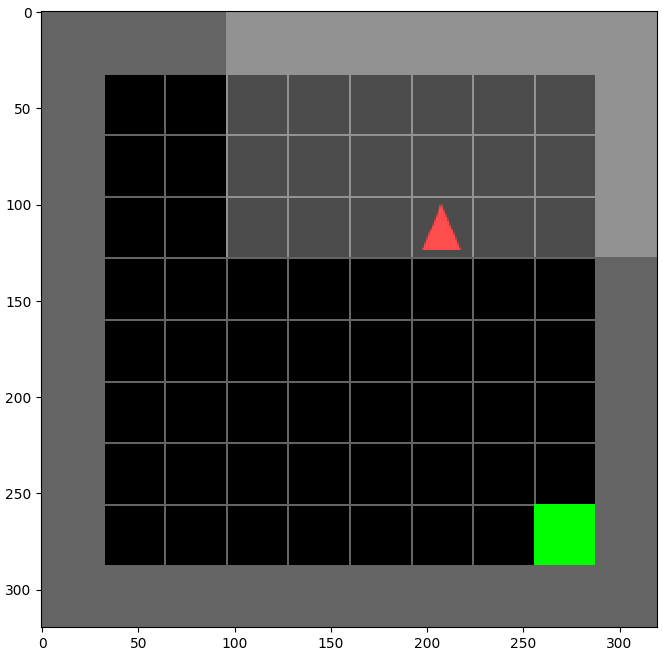

## Action Space

| Num | Name    | Action      |
|-----|---------|-------------|
| 0   | left    | turn left   |
| 1   | right   | turn right  |
| 2   | forward | move forward|


## Observation Encoding

Agent Direction,
Agent Position,
Goal Position

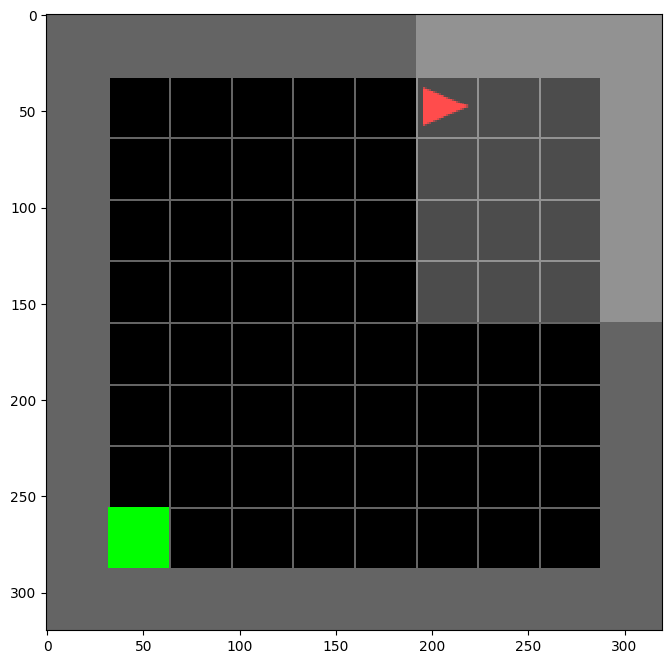

In [202]:
env = KeyFlatObsWrapper(RandomEmptyEnv_10 (render_mode='rgb_array'))
obs = env.reset()
screen = env.render()
plt.imshow(screen);

In [182]:
action_space = env.action_space
num_actions = action_space.n
print(f"Number of actions: {num_actions}")


Number of actions: 3


Map Height: 8
Map Width: 8
Agent Direction: 3
Agent Position: (6, 2)
Goal position:  (1, 8)


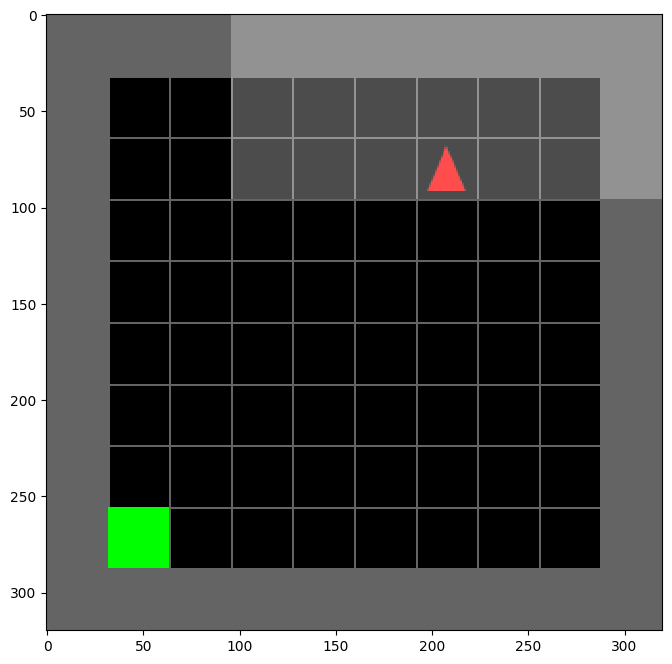

In [183]:
obs = env.reset()
# ============================================
screen = env.render()
plt.imshow(screen)
print('Map Height:', env.height-2)
print('Map Width:', env.width-2)
print('Agent Direction:', env.get_direction())
print('Agent Position:', env.get_position())
print('Goal position: ', env.get_goal_pos())

## Solving the environment

Before inspecting the hyperparameters in depth, let's first present a solution for the environment:

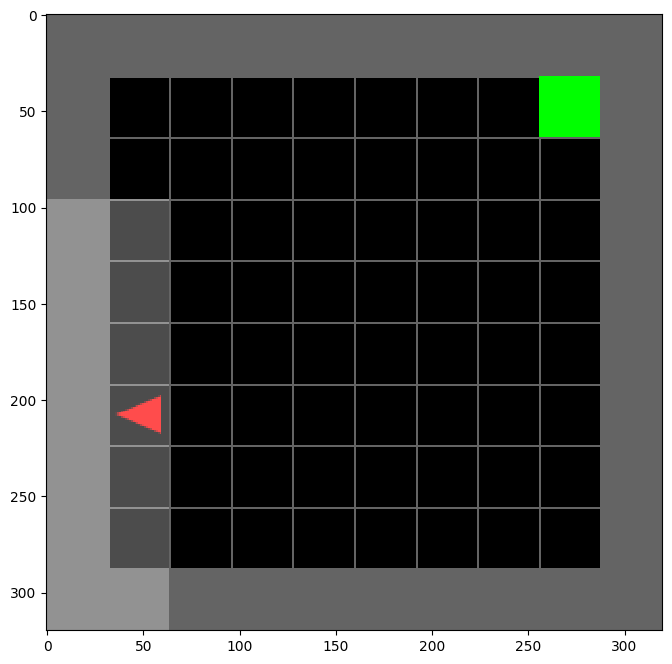

In [201]:
# create and render the env
random.seed(42)
source_env = KeyFlatObsWrapper(RandomEmptyEnv_10(render_mode='rgb_array'))
source_env.reset()
env = EmptyEnvWrapper(source_env, state_representation=StateRepresentation.ENCODED)
plt.imshow(env.render());

In [186]:
algorithm_params_cpy = algorithm_params.copy()
algorithm_params_cpy['env'] = env

mid_train_policy, policy, states_visits_mean, done_count, episodes_steps, episodes_rewards = q_learning(**algorithm_params_cpy)

stream mid-training policy:

In [187]:
stream_policy(env, mid_train_policy)

video file name: video_1.mp4


stream final policy:

In [188]:
stream_policy(env, policy)

video file name: video_2.mp4


From the videos, it's evident that the agent quickly discovers the necessary policy, even before reaching the midpoint of training.
To gain a clearer understanding, let's now examine the training policy in more detail.

Monitoring where the agent visited during training:

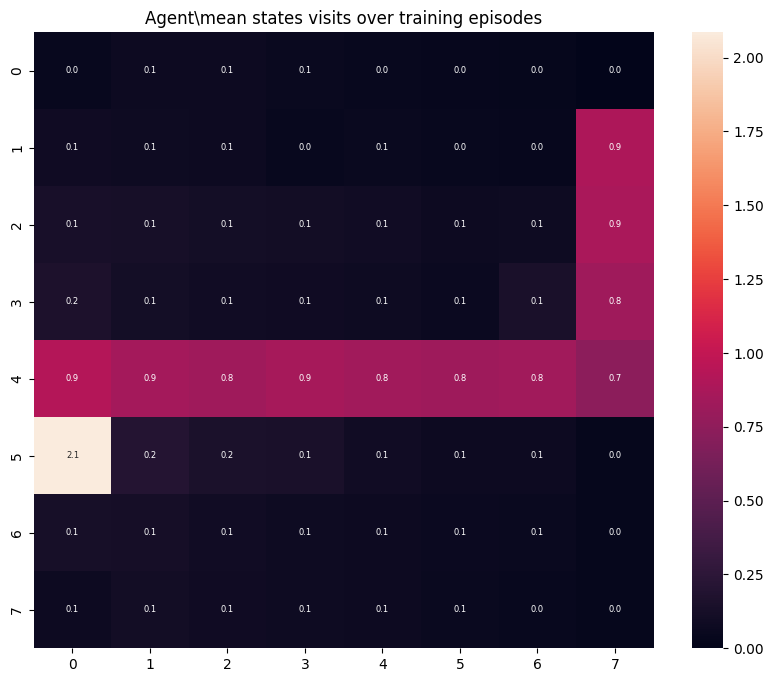

In [189]:
sns.heatmap(states_visits_mean.T, annot=True, fmt='.1f', annot_kws={"size": 6})
plt.title('Agent\\mean states visits over training episodes');

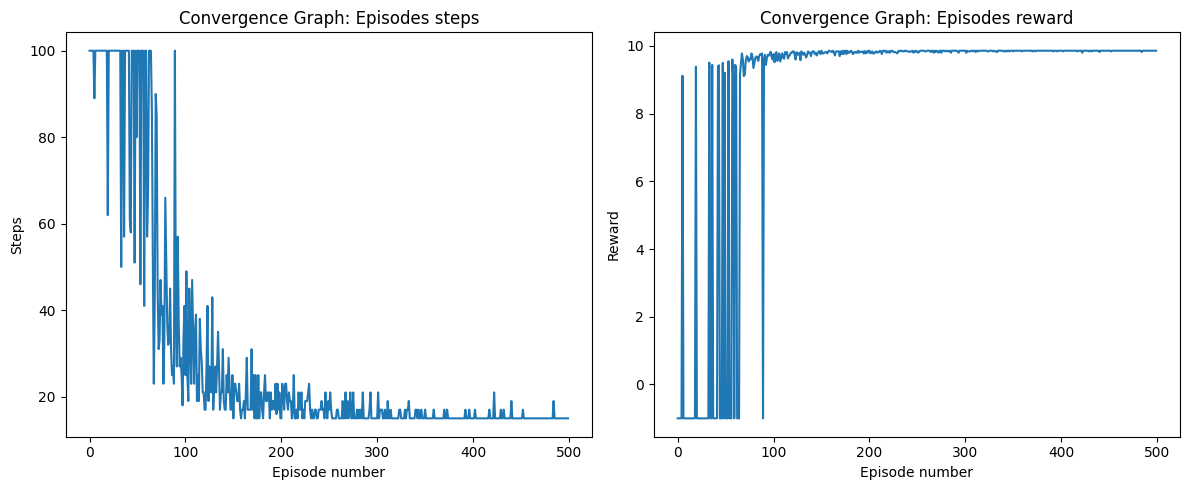

In [203]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5)) # Creates 1 row, 2 columns of plots, adjust figsize as needed

# Plot Episodes steps on the first subplot
axs[0].plot(episodes_steps)
axs[0].set_title('Convergence Graph: Episodes steps')
axs[0].set_xlabel('Episode number')
axs[0].set_ylabel('Steps')

# Plot Episodes reward on the second subplot
axs[1].plot(episodes_rewards)
axs[1].set_title('Convergence Graph: Episodes reward')
axs[1].set_xlabel('Episode number')
axs[1].set_ylabel('Reward')

plt.tight_layout() # Adjusts subplots to fit into the figure area.

## Hyperparameters comparison - environment hyperparameters

This section delves into adjusting key environment hyperparameters, namely the goal reward and the step reward (which becomes a penalty when negative) while keeping everything else unchanged.

### Goal reward

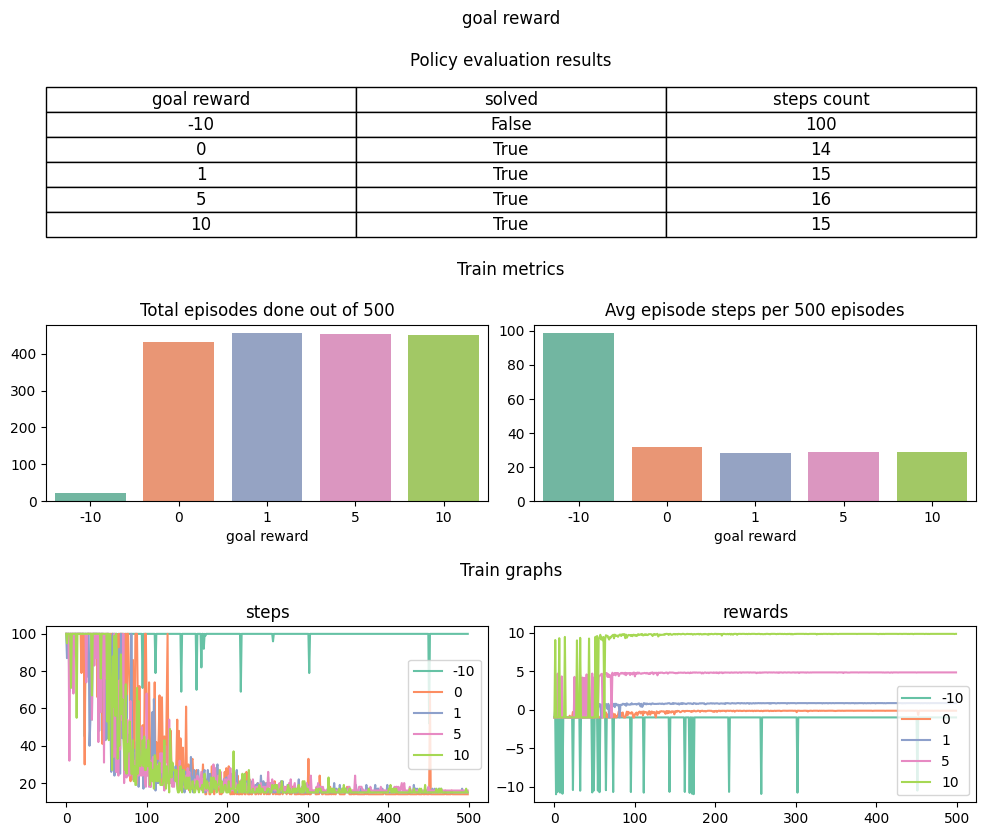

In [192]:
tested_parameter = 'goal_reward'
run_experiment(env=env, env_params=env_params, 
                algorithm=q_learning, algorithm_params=algorithm_params,
                tested_parameter=tested_parameter, tested_values=tested_parameters[ENV_PARAMS][tested_parameter])

### Step reward

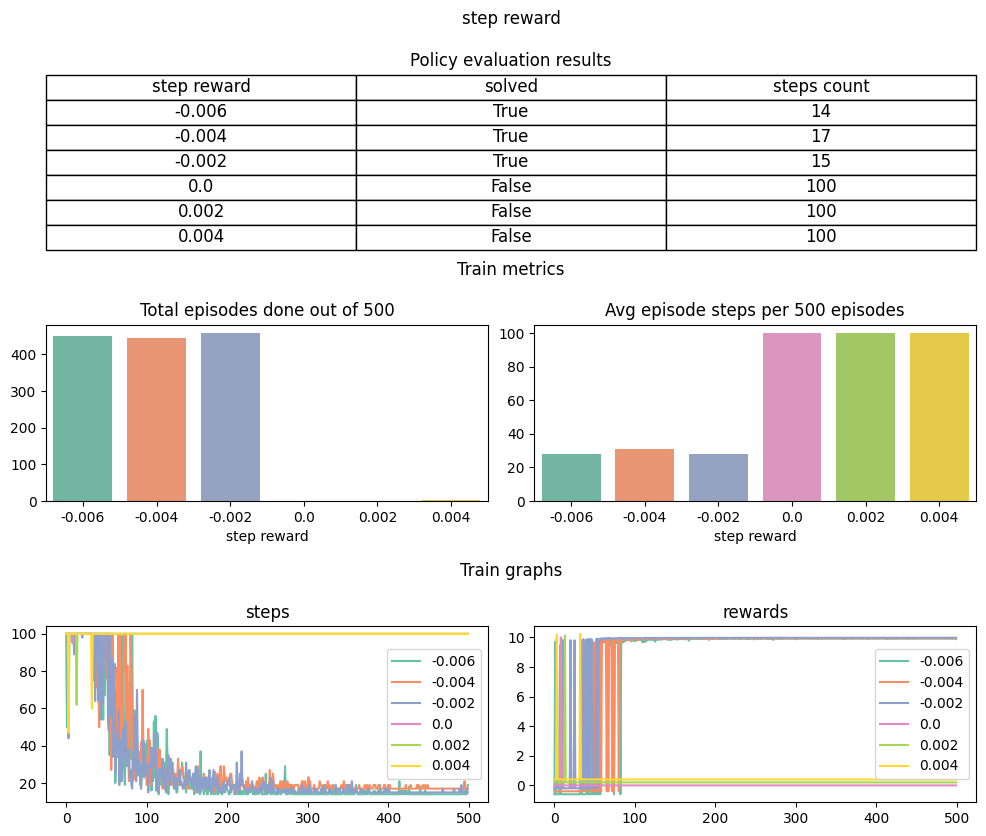

In [193]:
tested_parameter = 'step_reward'
run_experiment(env=env, env_params=env_params, 
                algorithm=q_learning, algorithm_params=algorithm_params,
                tested_parameter=tested_parameter, tested_values=tested_parameters[ENV_PARAMS][tested_parameter])

## Hyperparameters comparison - algorithm hyperparameters

In this section we will explore the effects of adjusting various hyperparameters of the algorithm (alpha, gamma and epsilon decay) while keeping the rest unchanged.

### Alpha

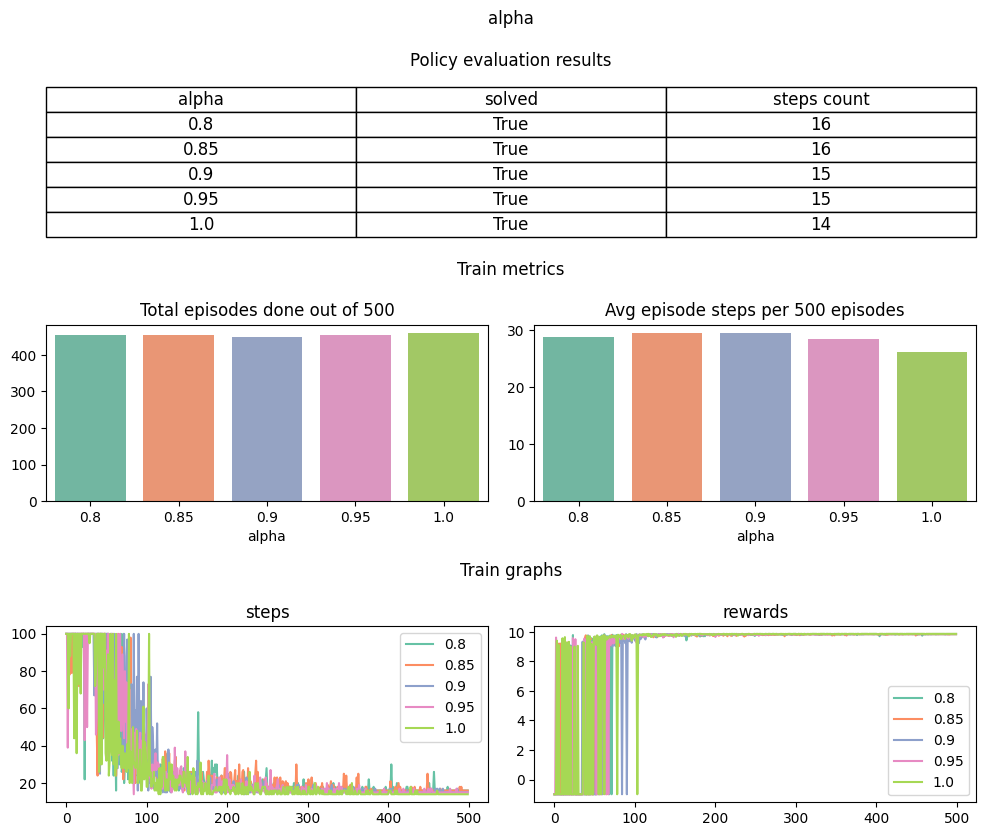

In [194]:
tested_parameter = 'alpha'
run_experiment(env=env, env_params=env_params, 
                algorithm=q_learning, algorithm_params=algorithm_params,
                tested_parameter=tested_parameter, tested_values=tested_parameters[ALGO_PARAMS][tested_parameter])

### Gamma

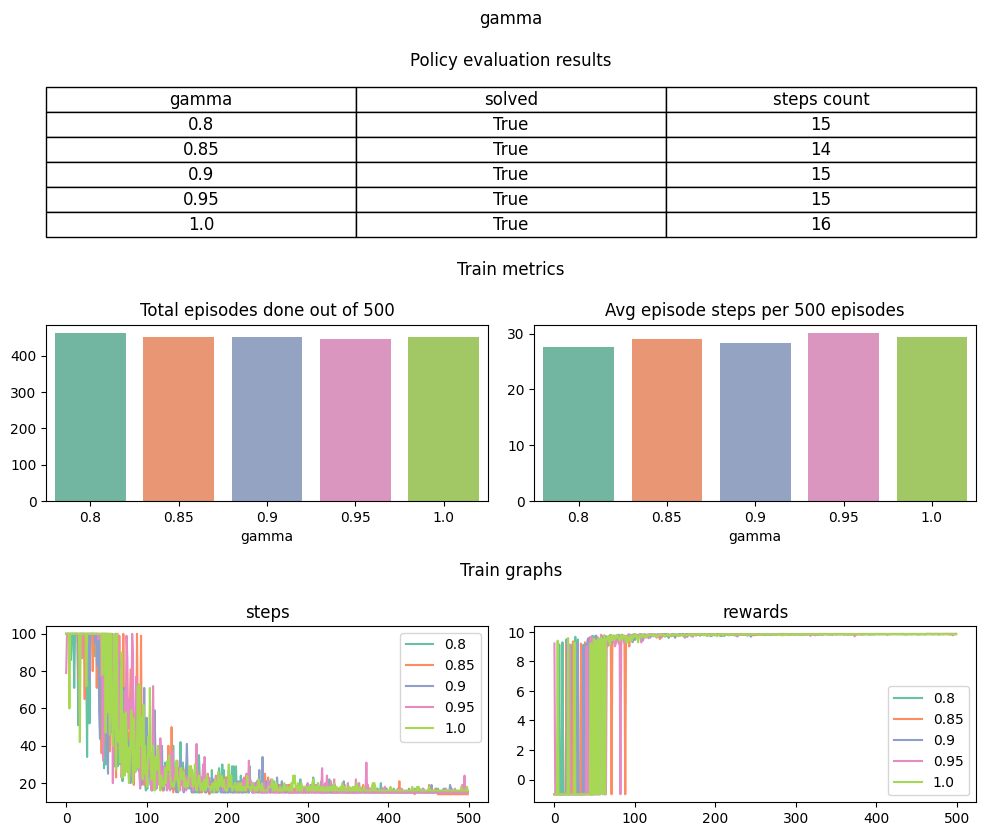

In [195]:
tested_parameter = 'gamma'
run_experiment(env=env, env_params=env_params, 
                algorithm=q_learning, algorithm_params=algorithm_params,
                tested_parameter=tested_parameter, tested_values=tested_parameters[ALGO_PARAMS][tested_parameter])

### Epsilon Decay

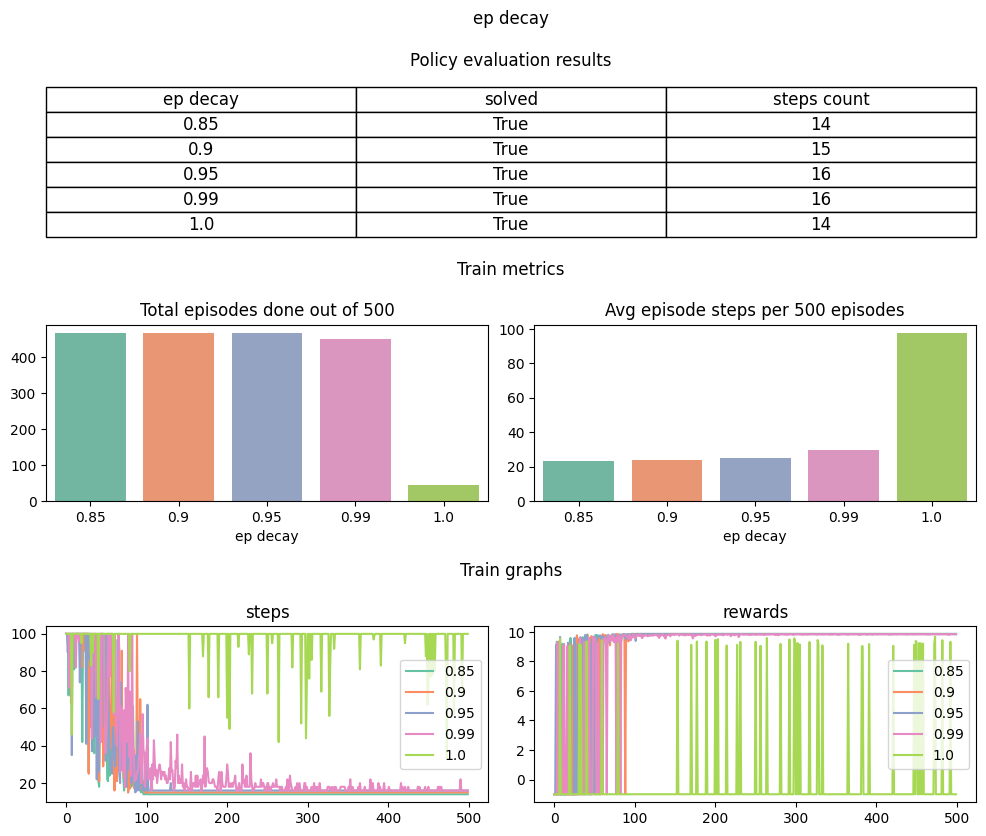

In [196]:
tested_parameter = 'ep_decay'
run_experiment(env=env, env_params=env_params, 
                algorithm=q_learning, algorithm_params=algorithm_params,
                tested_parameter=tested_parameter, tested_values=tested_parameters[ALGO_PARAMS][tested_parameter])

# RandomKeyMEnv_10

###Description

This environment has a key that the agent must pick up in order to unlock a goal and then get to the green goal square.

Wall is always in the third column

Key is always in the left part (left to the door)

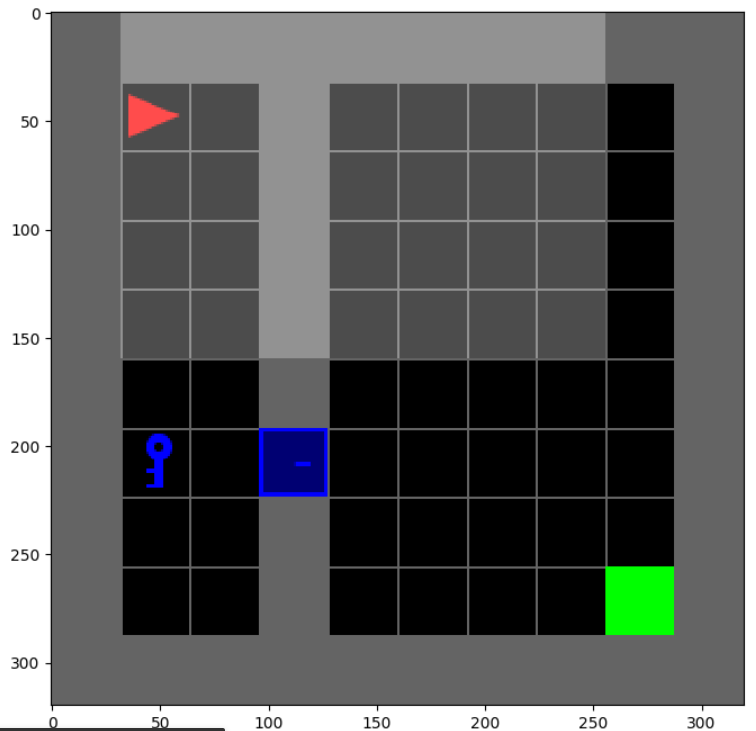

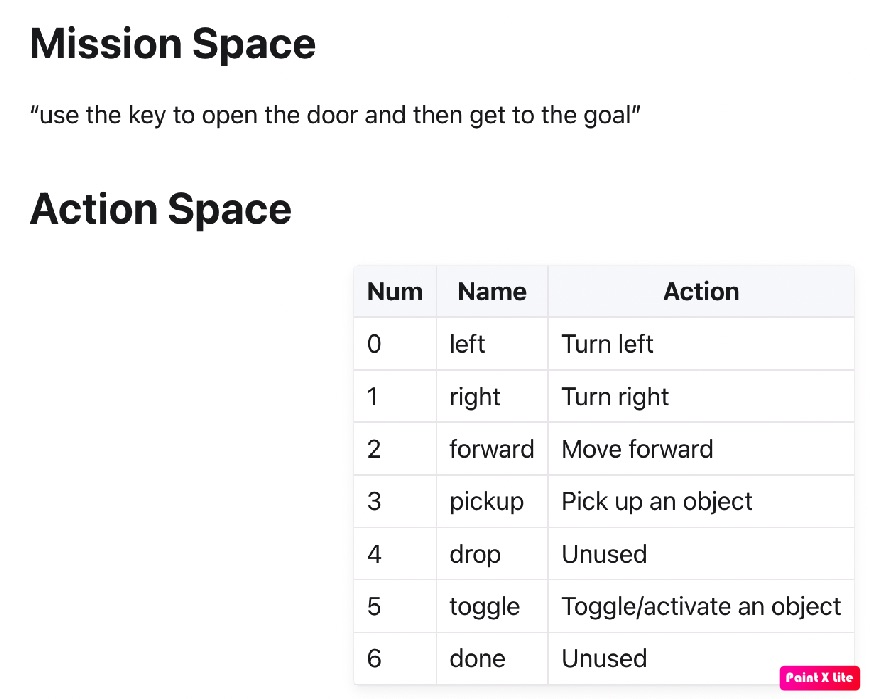

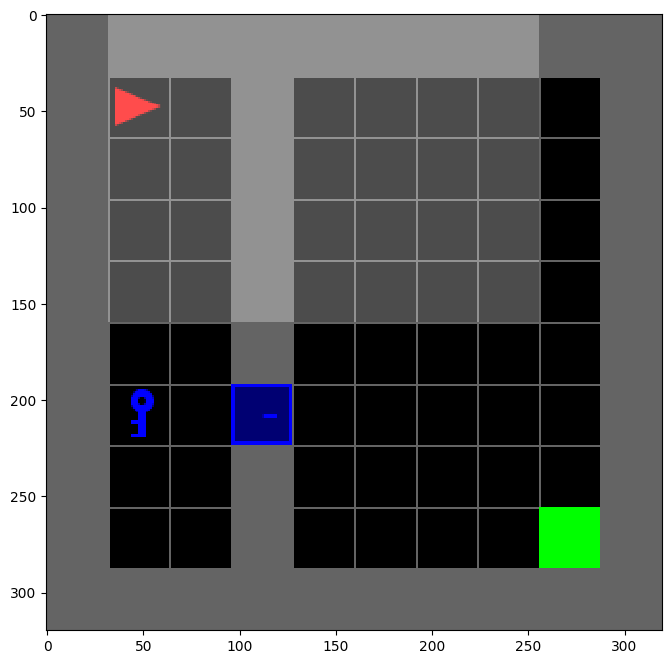

In [197]:
#=============== DO NOT DELETE ===============
# random.seed(42)
env = KeyFlatObsWrapper(RandomKeyMEnv_10 (render_mode='rgb_array'))
#env = KeyFlatObsWrapper(KeyMazeEnv_10(render_mode='rgb_array'))

obs = env.reset()
# ============================================
screen = env.render()
plt.imshow(screen)

In [198]:
action_space = env.action_space
num_actions = action_space.n
print(f"Number of actions: {num_actions}")

Number of actions: 7


Door is opened? :  False
carrying Key? :  False
Agent Direction: 0
Agent Position: (1, 1)
Is there a wall in from of the Agent? :  False
Goal position:  (8, 8)
Key Position: (2, 2)
Door Position: (3, 5)


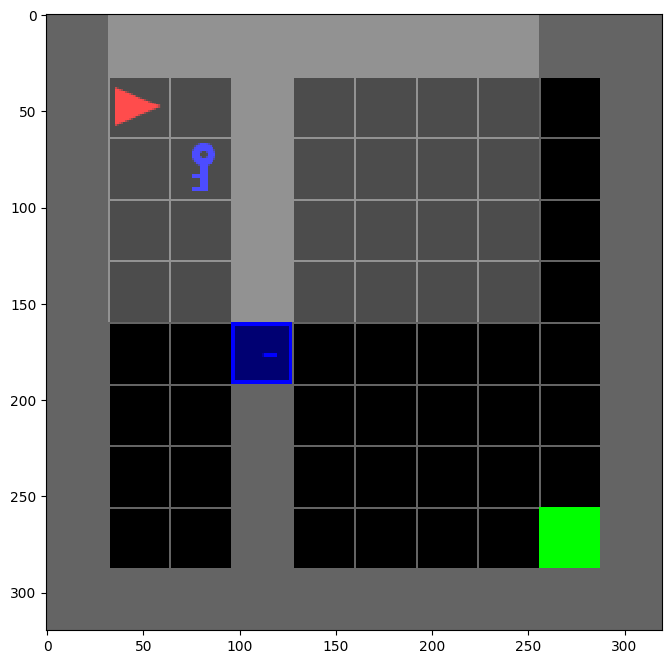

In [199]:
env = KeyFlatObsWrapper(RandomKeyMEnv_10 (render_mode='rgb_array'))
obs = env.reset()
# ============================================
screen = env.render()
plt.imshow(screen)
print('Door is opened? : ', env.is_door_open())
print('carrying Key? : ',env.is_carrying_key())
print('Agent Direction:', env.get_direction())
print('Agent Position:', env.get_position())
print('Is there a wall in from of the Agent? : ', env.is_wall_front_pos())
print('Goal position: ', env.get_goal_pos())
print('Key Position:', env.get_k_pos())
print('Door Position:', env.get_d_pos())